## Work package 2.1 
### Delivering ...:
1. Methods (notebook) for compiling short-term time-series  (e.g., monthly)  of EO data for WQ monitoring: 
- 1.1 Filtering of outliers and inferior data (insufficient radiation, glint, shadowing, bottom-reflectance) 
- 1.2 Apply corrections (dark-pixel subtraction)
- 1.3 Define areas of water (at time of observation)
- 1.4 Compilation to bi-monthly and monthly values

Time-series will need to cover: 
Baseline period
Monitoring period
Time of observation (i.e., recent)


### Dependencies etc.

In [3]:
# --- --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
import json
from scipy import stats
import pandas as pd     #for dates
from odc.ui import image_aspect
from deafrica_tools.plotting import rgb # used in some visualisation for debugging
dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [191]:
# --- run code for functions that are called
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown
%run /home/jovyan/dev/deafrica_water_quality/WP2.1/QA_functions.ipynb                # contains functions to compare pixels to the geomedian


In [5]:
# --- controlling parameters and settings
verbose = True 
test    = False
# --- the number of cells in the spatial domain (x,y) used to analyse the waterbody ; Data are resampled guided by this limit 
max_cells = 100000   
max_cells = 50000   #use this to test memory limits. Memory saving steps are going to be needed...

#### Set the place and time interval
- for development here I call on a dictionary of reference sites defined in the function set_spacetime_domain()
- the time interval is set specifically since each waterbody has its own 'interesting' times

In [7]:
# --- get the dictionary of all possible places for analysis ---

places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
year1, year2 = None, None
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename,year1,year2 = 'Lake Chamo','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Ziway','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Awassa','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake_Manyara','2015-12-01','2016-03-31'   
placename,year1,year2 = 'SA_smalldam','2020-01-01','2020-12-31' 
placename,year1,year2 = 'Lake_vic_algae','2018-1-01','2018-07-10'
placename,year1,year2 = 'Lake_vic_kisumu','2019-01-01','2019-12-31'
placename,year1,year2 = 'Lake_Manyara','2015-12-01','2016-03-31'   



# a good example for monitoring - (35.7236, 35.9286) (-3.8135, -3.4085), late 2015, to 2016-02-16   
# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(
                               placename,
                               #'2015-12-01','2016-03-31',
                               #'2018-1-01','2018-07-10',
                               year1 = year1, year2 = year2,
                               max_cells = max_cells,
                               verbose=verbose,test=False)



Lake_Manyara AOI:  {'x': (35.724, 35.929), 'y': (-3.814, -3.409), 'time': ('2015-12-01', '2016-03-31')} Lake_Manyara, Tanzania
Grid resolution will be: (120, 120)
Rough dimensions (x,y):  20  by  40 kilometres
Total cells is roughly:  57528
Cell area is:  0.0144  km2
Resampling : nearest
Site name:  Lake_Manyara, Tanzania
Years: 2015-12-01 2016-03-31


#### Filenames
- to allow processing steps to be separated, at least during development, data are written to files at key points, i.e.:
    - after compiling the time-series and running water quality variables but before wq variables are standardised
- water quality normalisation parameters are read in from a file produced in earlier processing steps

In [8]:
dataset_filename                     = '/home/jovyan/AdamsWork/scratch/wp21_ds_'+placename+'.nc'                         #used to save files between steps
dataset_agm_filename                     = '/home/jovyan/AdamsWork/scratch/wp21_ds_'+placename+'_agm.nc'                 #used to save files between steps
wq_normalisation_parameters_filename = '/home/jovyan/dev/deafrica_water_quality/WP1.4/wq_normalisation_parameters.json'   #normalisation parameters


### Build datasets, first the geomedians, then a time-series from individual observations using TM, OLI, MSI (at this point)
- assume we are working with data for a short interval of time, upto 2 years max
- Build Geomedian dataset (TM, OLI, MSI as available)
- Build observation dataset (TM, OLI, MSI, as available, TIRS to follow)
- Detect outliers in the observations by reference to the geomedian and MADS
- Calculate NDVI values and harmonise locally using distribution matching
- Extract estimates of the percentage area of floating photosynthetic material 
### working on these:
- Extract a time-series of Chla values / trophic state referenced to the geomedian values
- Extract a time-series of TSS values / turbidity referenced to the geomedian values


### Part 1. Extract a multi-sensor dataset of annual geomedians
- keeping all data in a single dataset
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- instrument names are used rather than satellite names, to avoid confusion. For these purposes, wofs is also an instrument name
- re-using functions developed for the annual time-series where possible

In [9]:
# Build the annual (geomedian) dataset
# --- set which instruments to use (this is checked later against the date range for each place)
# --- The geomedians are retained as a reference for filtering of outliers.
# --- The returned dataset should have everything in one ..
# --- switch off the non-annual datasets to allow the annual build function to be used separately 

_instruments_to_use = {
    'oli_agm'  : {'use': True },
    'oli'      : {'use': False},
    'msi_agm'  : {'use': True },
    'msi'      : {'use': False},
    'tm_agm'   : {'use': True },
    'tm'       : {'use': False},
    'tirs'     : {'use': False},  
    'wofs_ann' : {'use': True },
    'wofs_all' : {'use': False},  # wofs_all will be removed as it is better to derive from wofs_ann
    }

instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

# --- for a couple of purposes extract the year from the start and end times ..
y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]
 
# --- don't try to use instruments for which there are no data#

check_instrument_dates(instruments_to_use,y1,y2,False)

# --- build the multivariate/multi-sensor dataset. 
#     Datacube calls are made to extract the primary data. 
#     Variables are-re-named and merged to a single dataset ---

#build the annual dataset first:
spacetime_domain_ann = spacetime_domain.copy()
if y1 == y2: y1 = y2 - 1
spacetime_domain_ann['time'] = (str(y1),str(y2))

ds_annual =  build_wq_agm_dataset(spacetime_domain_ann,instruments_to_use,verbose)

instruments_agm = instruments_list(instruments_to_use)[0]  # a list of the instruments  in use
print("\n Annual (geomedian) datasets loaded")


Building the dataset:
loading data for  oli_agm ...
loading data for  wofs_ann ...

 Annual datasets loaded


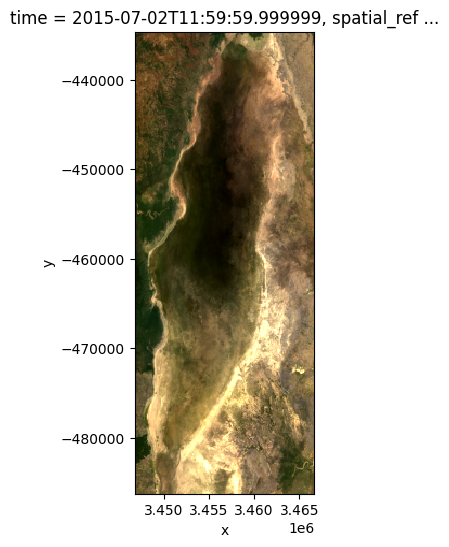

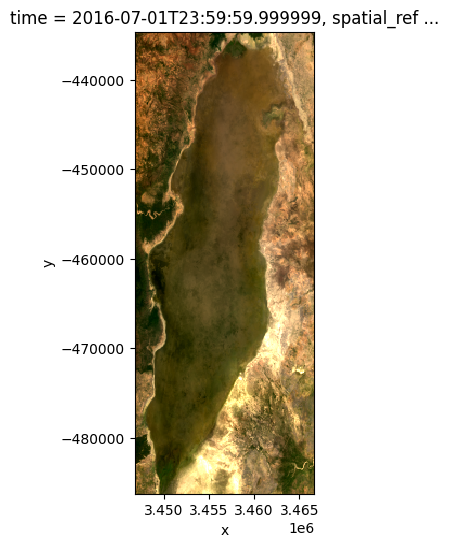

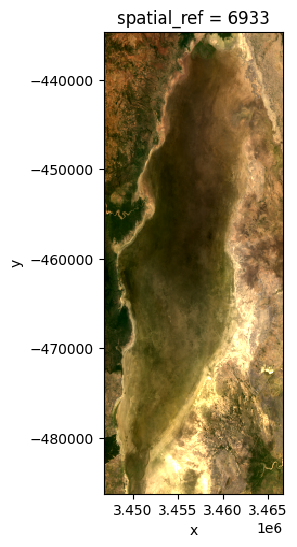

In [174]:
# this cell is purely to visualise the material during the development process
rgb(ds_annual.isel(time=0),bands=['oli04_agm','oli03_agm','oli02_agm'])
rgb(ds_annual.isel(time=1),bands=['oli04_agm','oli03_agm','oli02_agm'])
rgb(ds_annual.mean(dim='time'),bands=['oli04_agm','oli03_agm','oli02_agm'])
         

### Part 2. Extract a multi-sensor dataset from the primary observations (satellite images)
- keeping all data in a single dataset
- a dictionary of instruments and sensors is used to rename all measurements to a common form
- re-using functions developed for the annual time-series where possible
- each instrument must be individually prepared to some degree 

In [11]:
# Build time-series / indivitual time-slices dataset ---

_instruments_to_use = {
    'oli_agm'  : {'use': False },
    'oli'      : {'use': True},
    'msi_agm'  : {'use': False },
    'msi'      : {'use': True},
    'tm_agm'   : {'use': False },
    'tm'       : {'use': True},
    'tirs'     : {'use': True},  
    'wofs_ann' : {'use': False },
    'wofs_all' : {'use': False },  # wofs_all will be removed as it is better to derive from wofs_ann
    }
instruments_to_use = _instruments_to_use.copy()  #using a copy is helpful sometimes..

y1 = pd.DatetimeIndex([year1]).year[0]
y2 = pd.DatetimeIndex([year2]).year[0]

check_instrument_dates(instruments_to_use,y1,y2,False)

products = { 
                'tm_agm'  :["gm_ls5_ls7_annual"],
                'tm'      :["ls5_sr","ls7_sr"],
                'oli_agm' :["gm_ls8_annual","gm_ls8_ls9_annual"],
                'oli'     :["ls8_sr","ls9_sr"],
                'msi_agm' :["gm_s2_annual"],
                'msi'     :["s2_l2a"],
                'tirs'    :["ls5_st","ls7_st","ls8_st","ls9_st"],
                'wofs_ann':["wofs_ls_summary_annual"],
                'wofs_all':["wofs_ls_summary_alltime"],
               }

instruments,measurements,rename_dict = instruments_list(instruments_to_use) 
data_list = {}

if instruments_to_use['oli']['use']:
    print('building the oli dataset...')
    instrument = 'oli'
    # --- load oli data
    # Load available data from all three Landsat satellites
    ds_oli = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_oli = rename_vars_robust(ds_oli,rename_dict['oli'])
    # --- set zeros to nans and re-scale 
    for var in ds_oli.data_vars:
        ds_oli[var] = xr.where(ds_oli[var]>0,ds_oli[var],np.nan)
        if not var == 'oli_pq':
            ds_oli[var] = ((ds_oli[var] * 0.0000275) - 0.2) * 10000

    data_list['oli'] = ds_oli
    print('... done.')
    

if instruments_to_use['msi']['use']:
    print('building the msi dataset....')
    instrument = 'msi'
    test = True
    # --- load msi data
    ds_msi = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)
    # --- re-name the variables for the sake of sanity --- 
    ds_msi = rename_vars_robust(ds_msi,rename_dict['msi'])
    # --- set zeros to nans and re-scale 
    for var in ds_msi.data_vars:
        ds_msi[var] = xr.where(ds_msi[var]>0,ds_msi[var],np.nan)
        #if not var == 'msi_pq':
        # no rescaling? 

    data_list['msi'] = ds_msi
    print('... done.')
    

if instruments_to_use['tm']['use']:
    print('building the tm dataset ...')
    instrument = 'tm'
    # --- load tm data
    ds_tm = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

    # --- re-name the variables for the sake of sanity --- 
    ds_tm = rename_vars_robust(ds_tm,rename_dict['tm'])
    

    # --- set zeros to nans and re-scale 
    for var in ds_tm.data_vars:
        ds_tm[var] = xr.where(ds_tm[var]>0,ds_tm[var],np.nan)
        if not var == 'tm_pq':
            ds_tm[var] = ((ds_tm[var] * 0.0000275) - 0.2) * 10000

    data_list['tm'] = ds_tm
    print('... done.')

#yet to switch this on...
if instruments_to_use['tirs']['use'] and False:
    test = True
    print('building the tirs dataset ...')
    instrument = 'tirs'
    data_list.append(instrument)
    # --- load tirs data
    ds_tm = dc.load(product=(products[instrument]),
                                 **spacetime_domain,
                                 **{'measurements': measurements[instrument]},
                                 output_crs='epsg:6933',
                                 group_by ='solar_day',
                                 resolution=grid_resolution,
                                 align=(0,0),
                                 resampling=resampling_option,)

    # --- re-name the variables for the sake of sanity --- 
    ds_tirs = rename_vars_robust(ds_tirs,rename_dict['tirs'])

    # --- set zeros to nans and re-scale 
    for var in ds_tirs.data_vars:
        ds_tm[var] = xr.where(ds_tm[var]>0,ds_tm[var],np.nan)
        if not var == 'tm_pq':
            ds_tm[var] = ((ds_tm[var] * 0.0000275) - 0.2) * 10000
    data_list['tirs']=ds_tirs
    print('... done.')

print('Data list = ',data_list.keys(),'\n')
print('done\n')
    

building the oli dataset...
... done.
building the tm dataset ...
... done.
Data list =  dict_keys(['oli', 'tm']) 

done



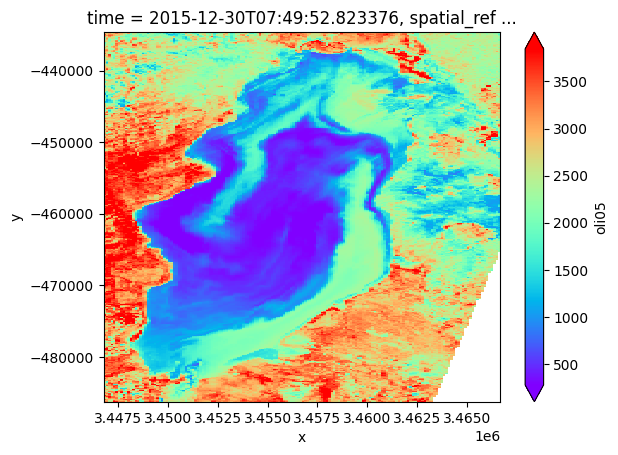

In [175]:
if verbose : 
    
    ds_oli.oli05.isel(time=3).plot(cmap='rainbow',robust=True)

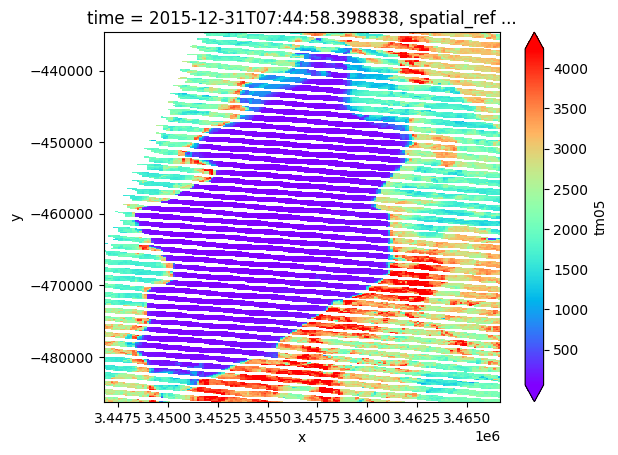

In [14]:
if verbose : 
    ds_tm.tm05.isel(time=3).plot(cmap='rainbow',robust=True)
#ds_annual.oli05_agm.isel(time=0).plot(cmap='rainbow',robust=True)

### Filter outliers 
#### Rather than rely on pq channels to detect clouds etc., I use the geomedians and mads as a reference. 

The deviation of each data point from the geomedian is compared mean absolute deviation using two indepenent tests.
Outliers are identified by refence to a combined threshold, and flagged with a continuous variable qa_score such that:
- 0 > qa_score    : implies an outlier.
- 0 < qa_score <= 1:  implies data that are to be expected in the data given the geomedian and MAD values.

All outliers are retained in the dataset. Outliers with plausible spectral reflectances indicate change. They are used in the identification of floating photosynthetic material such as water hyacinth.

Datasets with a large percentage of outliers may be rejected as unreliable.

For any given year, only one geomedian is produced (e.g., a Landsat TM geomedian is not produced in years when OLI is available). In these situations the TM data is compared to the OLI geomedian with good results. 


In [195]:
# Set agm_tests,  the variables to be used in the QA analysis
# --- specify the variables to compare when calculating spectral angle and albedo divergences against the geomedian
#     Spelling out all the bands to allow contingency here for comparison of tm with oli_agm (which allows us to 
#     extend the use of tm past 2013, esp to include L7 data   ---
# --- the 'noIRband' version remove the IR band from the assessment. 
#     The IR band picks up floating vegetation giving wide variations in spectral angle relative to the geomedian; these deviations are valid
#     for wq purposes, but unusual enough to not be anticipated by the geomedian SMAD. This option allows those extremes to pass 
#     the QA test.

agm_tests   =   geomedian_test_bands()

### Calculate QA scores. 
Two orthogonal measures are very effective in filtering outliers especially poor data and cloud
#### ralb 
- Relative ALBedo deviation, per pixel
#### rsad 
- Relative Spectral Angle Deviation, per pixel

#### qa_score - the 'final' variable in the dataset
QA, normalised against a chosen threshold such acceptable values fall in the range of 0-1 (outliers are negative), where:
- QA is the combined deviation, calculated as the magnitude of the vector [rsad *w, ralb] where,
- w is an empirical weight (0.4 in practice) to permit more variation in rsad when the measures are combined in this way.
- -inf < qa_score < 1.
- qa_score > 0 implies good data.

#### DQA 
Dataset-level deviation, a fraction of pixels with rsad and ralb in reasonable range. DQA has one value for each observation time.
- nominal 'reasonable range' is set by 3n in the formulae above.

### Notes:
- the approach here has greater flexibility than taking pre-canned qa scores (and that flexibility is necessary). I suspect it is also just better, but that remains to be objectively tested.
- white clouds give very high RALB and high RSAD. Some illumination changes leave data values within normal ranges (wispy cloud, cloud shadow)
- change in the nature of the surface leads to high RSAD with normal RALB
- cloud shadow leads to low values of RALB 
- fine-tuning is possible by selecting specific filters of rsad and ralb, (for example to let more data in for ndvi calculations) but the default is pretty good. 
- a lot of experimentation to determine the thresholds used here, but the process seems quite robust and outcomes are unlikely to be changed by small changes in the parameters used in this QA process


In [194]:
# --- Calculate QA scores  ( re-worked to simplify / streamline and save memory through calling the qa tests once for each time index)
# --- This is fiddly because each instrument needs to be handled differently (the end result being a common qa_score)

# --- Set thresholds. These are based on experimentation. If the combined deviation is less than the threshold the qa_score will be > 0
# ---- the value of 1.4 is about the equivalent of one standard deviation (literature says 1.48 for a normal distribution)
thresholds = {}
thresholds['oli']  = 1.4 * 2   # this seems best ...
thresholds['msi']  = 1.4 * 2   # this seems best ...
thresholds['tm']   = 1.4 * 3   # should need higher threshold for tm v oli ... permitting more sensor variation ...

rsad_factor    = 0.4   # --- allow more variation in spectral angle than in brightness when calculating the combined QA measure

# --- initiate a dictionary to hold the datasets for each sensor, until they can be combined ---
datasets = None
for instr in list(('msi','oli','tm')):
    
    if instr in data_list.keys():        
        # --- the statistic to be used to normalise to 'relative' deviations
        bcmad_var = instr+'_agm_bcmad'
        smad_var  = instr+'_agm_smad'

        # --- set the specific combination of bands to be used for the qa tests
        if instr == 'msi' : 
                data_band_list      = agm_tests['msi-v-msi_agm-noIRband']['msi']
                geomedian_band_list = agm_tests['msi-v-msi_agm-noIRband']['msi_agm']
        if instr == 'oli' : 
                data_band_list      = agm_tests['oli-v-oli_agm-noIRband']['oli']
                geomedian_band_list = agm_tests['oli-v-oli_agm-noIRband']['oli_agm']
        if instr == 'tm' : 
            data_band_list      = agm_tests['tm-v-tm_agm-noIRband']['tm']
            geomedian_band_list = agm_tests['tm-v-tm_agm-noIRband']['tm_agm']
            start_year           = int(data_list[instr].time[0].dt.year.item()) # returns the year of the earliest obs from this sensor
            if start_year > 2012 :  #special case since tm geomedian not available after 2012 - compare with the oli agm instead
                data_band_list      = agm_tests['tm-v-oli_agm-noIRband']['tm']
                geomedian_band_list = agm_tests['tm-v-oli_agm-noIRband']['oli_agm']
                bcmad_var           = 'oli_agm_bcmad'
                smad_var            = 'oli_agm_smad'
        
        # --- set up the dataset and create new variables to receive the qa data
        #     notice that at this point we drop the reference to the instrument (instrument-agnostic)
        ds_instr = data_list[instr]
        ralb     = 'qa_ralb'
        alb      = 'qa_alb'
        sizes    = ds_instr.sizes
        ds_instr[ralb] = ('time','y','x'), np.ones((sizes['time'],sizes['y'],sizes['x']))
        ds_instr[alb]  = ('time','y','x'), np.ones((sizes['time'],sizes['y'],sizes['x']))
        
        # --- iterate through the time domain to process 
        for t in ds_instr.time :
            gm_year = str(t.dt.year.item())  # take geomedian from this year
    
            ds_instr[ralb].loc[{'time':t}] = \
                relative_albedo(
                    data                = ds_instr.loc[{'time':t}],
                    geomedian           = ds_annual.sel(time=gm_year,method = 'nearest').squeeze(),
                    data_band_list      = data_band_list,
                    geomedian_band_list = geomedian_band_list,
                    mad_var             = bcmad_var,            
                    verbose             = False,
                    test                = False) 
    
        # --- compensate for not including the IR bands ---
        ds_instr[ralb] = 6/4 *     ds_instr[ralb]
        ds_instr[alb]  = 6/4 *     ds_instr[alb] 
    
        # --- process for the relative spectral angle --- 
        rsad           = 'qa_rsad'
        sad            = 'qa_sad'
        ds_instr[rsad] = ('time','y','x'), np.ones((sizes['time'],sizes['y'],sizes['x']))

        # --- iterate through the time domain to process 
        for t in ds_instr.time :
            gm_year = str(t.dt.year.item())  # take geomedian from this year
    
            ds_instr[rsad].loc[{'time':t}] = \
                relative_spectral_angle_deviation(
                    data                = ds_instr.loc[{'time':t}],
                    geomedian           = ds_annual.sel(time=gm_year,method='nearest').squeeze(),
                    data_band_list      = data_band_list,
                    geomedian_band_list = geomedian_band_list,
                    mad_var             = smad_var,            
                    verbose             = False,
                    test                = False) 

        # --- combine ralb and rsad, allowing more variation in the spectral angle than in the albedo
        #     the raw qa is the magnitude of the vector [rsad,ralb] assuming orthogonality. 
        #     The qa is then scaled against the sensor-specific threshold, so that:
        #     QA_score: 0-1  => accept 
        #     QA_score: < 0  => reject, (lesser QA implies more wrong)

        ds_instr['qa_score'] = (ds_instr[ralb]**2 + (ds_instr[rsad] * rsad_factor)**2) ** 0.5
        ds_instr['qa_score'] = 1 - ( ds_instr['qa_score'] / thresholds[instr] )

        # --- keeping this for now, 'ci' is change indicator ... 
        ds_instr['ci_score'] = (ds_instr[rsad] * rsad_factor)-(ds_instr[ralb]**2)

### Calculate NDVI for each sensor
- ndvi > T is a threshold for assuming floating photosynthetic material / photosynthetic surface material (PSM). Area percentage is not very sensitive to this parameter.
- ndvi > 0.1 (or lower) is a threshold to not calculate water indices, since they are likely to be confounded 


In [180]:
# --- Calculate NDVI values for each instrument ----
ndvi_bands = {}
ndvi_bands['tm']  = ['tm04','tm03']
ndvi_bands['oli'] = ['oli05','oli04']
ndvi_bands['msi'] = ['msi8a','msi04']

for instr in list(('msi','oli','tm')):
    if instr in data_list.keys():  
        ds_instr = data_list[instr]
        # --- Calculate the ndvi for each sensor, keeping the instrument reference until harmonisation is figured out
        #     
        ds_instr[instr+'_ndvi'] = (ds_instr[ndvi_bands[instr][0]] - ds_instr[ndvi_bands[instr][1]]) / \
                                  (ds_instr[ndvi_bands[instr][0]] + ds_instr[ndvi_bands[instr][1]])
        

In [181]:
# --- Combine datasets, add references to the source, and restrict to water areas ---

first = True
for name in data_list.keys():
    if first:
        ds    = data_list[name]
        first = False
    else:
        ds = ds.combine_first(data_list[name])

# --- add boolean variables that retain the source instrument 
for instr in data_list.keys():
    ds[instr] = ('time'), np.zeros(ds.time.sizes['time']).astype('bool')
    for t in data_list[instr].time:
        ds[instr].loc[{'time':t}] = True

### Use the annual dataset with wofs to determine pixels that are water (sometimes, usually, permanent)

# --- controling parameters for water mapping on a pixel by pixel basis ---
WFTH = water_frequency_threshold_high = 0.5    #this threshold targets areas that are as like as not to be water at any time.
WFTL = water_frequency_threshold_low  = 0.1    #for pixel processing (rather than during summation)
PWT  = permanent_water_threshold      = 0.875  #used to map annual permanent water (value arrived at through testing)
SC   = sigma_coefficient              = 1.2    #used to map annual permanent water (value arrived at through tessting)
ds_annual   =      water_analysis(ds_annual,
                   water_frequency_threshold= WFTH,
                   wofs_varname             = 'wofs_ann_freq',
                   permanent_water_threshold= PWT,
                   sigma_coefficient        = SC,
                   verbose                  = verbose,
                   test                     = test)

# --- average water frequency for the dataset ---- 
ds['wofs_ann_freq'] = ds_annual.wofs_ann_freq.mean(dim='time')

# --- trim to water areas --- 
#     ds = ds.where(ds_annual.isel(time=0).wofs_ann_freq > 0.5,np.nan)  # this method bulks out the time-only variables to time,x,y...
#     mask array by array ...  
for var in list(ds.data_vars): 
    if ('x' in ds[var].sizes.keys()) and ('y' in ds[var].sizes.keys()) :
        ds[var] = ds[var].where(ds.wofs_ann_freq > 0.5,np.nan)
       

# --- calculate the total number of pixels in the water area ---
water_pixel_count = xr.where(ds_annual.isel(time=0).wofs_ann_freq > 0.5,1,np.nan).count().item()

# --- calculate the proportion of observations that are valid, at each time-step
ds['qa_percent'] = (
    (xr.where(ds.qa_score>0,1,np.nan).count(dim=('x','y')) * 100) / water_pixel_count
                    ).astype('int')

/opt/venv/lib/python3.12/site-packages/xarray/core/duck_array_ops.py:236: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


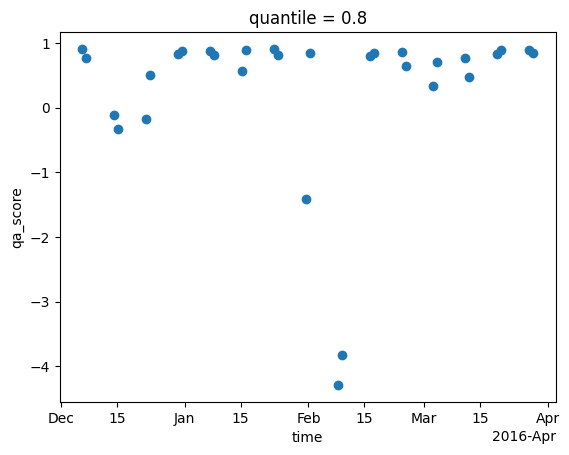

In [182]:
ds.qa_score.quantile(0.8,dim=('x','y')).plot(linestyle  = '',marker='o')

### Process the NDVI values over water areas
- The NDVI results from each sensor are brought into a single ndvi variable
- Histogram matching is used to adjust the OLI sensor to the MSI sensor, and then the TM sensor to the (adjusted) OLI
- NDVI is calculated over areas that would otherwise fail the QA test
- NDVI results are trimmed to 0-1; we are not intereseted in values less than zero
#### This approach is okay, although a more global approach to NDVI adjustment over water areas would be nice
- Methods of Kenta Obata (IGARSS paper) might be good if we have time to work them out adapt


In [43]:
# --- Calculate a common ndvi and reduce to places where the observations are clear 

ds['ndvi'] = ('time','y','x'), np.nan * np.zeros((ds.sizes['time'],ds.sizes['y'],ds.sizes['x']))

lst = list('')
for name in 'msi','oli','tm':
    if name in ds.data_vars:
        lst.append(name)

for t in ds.time:
    for name in lst:
        if ds.sel(time=t)[name]:
            ds['ndvi'].loc[{'time':t}] = ds[name+'_ndvi'].loc[{'time':t}]
            
# --- trim to reasonable range, dropping outliers ---

ds['ndvi'] = xr.where(ds.ndvi<-1,np.nan,
                          xr.where(ds.ndvi>1,np.nan,ds.ndvi)
                     )

# --- limit the ndvi to only aquisitions that are mostly free of cloud ---
#     note that the striping in landsat 7 makes it more prone to be cut at this point

ds['ndvi'] = xr.where(ds.qa_percent>60,ds.ndvi,np.nan)

# --- limit the ndvi to pixels that are not too far off the scale  
ds['ndvi'] = xr.where(ds.qa_ralb > -4,
                      xr.where(ds.qa_ralb < 4,ds.ndvi,np.nan),np.nan)

#ds['ndvi'] = xr.where(ds['ndvi'] >  1,np.nan,xr.where(ds['ndvi'] < -1,np.nan,ds['ndvi']))
ds['ndvi'] = xr.where(ds['ndvi'] < -1,np.nan,xr.where(ds['ndvi'] >  1,np.nan,ds['ndvi']))

ds['ndvi_total_count'] = ds.qa_score.where(np.logical_or(ds['qa_score']>0,~np.isnan(ds['ndvi']))).count(dim=('x','y'))


In [44]:
# --- a function to match histograms --- 'cpf' = cumulative probability function
#     this seems to work well; 
#     notice that have to use the xr.qantile method, rather than the np.quantile() function which does not manage the nans
#     To avoid replicating values it can be necessary for the number of bins to be only 5. A robust work-arond is needed;

def cpf_match(source_data,target_data,bins=11,method='quadratic') :
    Q = np.linspace(0,1,bins)         # --- array of quantiles, call it Q. Exclude extreme tails which can be out of range if there are data problems

    # --- calculate the quantiles (CPDs) for the source data and target data
    X = source_data.quantile(Q,skipna= True)
    Y = target_data.quantile(Q,skipna= True)

    # --- fit a model to X; ie Q = f(x)
    f = sp.interpolate.interp1d(X,Q,kind=method,fill_value='extrapolate')
    # --- fit an inverse model to Y; ie Y = g(Q)
    g = sp.interpolate.interp1d(Q,Y,kind=method,fill_value='extrapolate')
    # --- new values are given by g(f(x)), which is very cool 
    
    return xr.DataArray(g(f(source_data)),dims=source_data.dims)
    

In [92]:
# --- Carry out a two-step process of histogram matching over the dataset area.
#     Note that simple regression methods from Francesca Trevisiol et al IEEE TRANSACTIONS ON GEOSCIENCE AND REMOTE SENSING, VOL. 62, 2024
#      don't seem to work here. 
#     Histogram matching methods are inherently local; its only valid to match if the samples have observed the same domain.

# --- Two step process to leverage the temporal overlaps, first adjust oli to msi, then tm to oli and msi :
# --- further, run the process twice; the first removes extreme values and the second time matches only the positive values
for i in [1,2]:
 
    if 'msi' in ds.data_vars and 'oli' in ds.data_vars : 
    
        # --- first step, harmonise oli to msi, if the latter are available --- 
        ds['ndvi'] = xr.where(ds.oli,
                          cpf_match(ds.ndvi.where(ds.oli,),ds.ndvi.where(ds.msi)),
                          ds.ndvi)

    # --- repeat the process to harmonise the tm data to the adjusted oli data --- 
    if 'tm' in ds.data_vars and 'oli' in ds.data_vars :
        ds['ndvi'] = xr.where(ds.tm,
                          cpf_match(ds.ndvi.where(ds.tm),ds.ndvi.where(ds.oli)),
                          ds.ndvi)

    #--- deal with artefacts of ndvi > 1 ---
    ds['ndvi'] = xr.where(ds.ndvi>1,np.nan,
                      xr.where(ds.ndvi<-1,np.nan,
                               ds.ndvi))

    # --- limit the newly adjusted ndvi data to values above zero ---
    ds['ndvi'] = xr.where(ds.ndvi > 0,ds.ndvi,np.nan)
    

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.05   # results are not very sensitive to this parameter.... 

ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count
# done

In [ ]:
if verbose:
    plt.plot(

### Tidy up:
#### - Drop old datasets

In [93]:
# tidy up ...  
droplist = list([
                'ci_score',
                'oli_ndvi',
                'tm_ndvi',
                'msi_ndvi',
                'tm_pq',
                'oli_pq',
                'msi_qa']
               )
ds = ds.drop_vars(droplist,errors='ignore')

# --- remove old datasets
ds_tm = ds_oli = ds_msi = data_list = ''

#### - Drop those dates from the timeseries where the QA for that data collection date is below a threshold (e.g., < 20% of measurements are acceptable)

In [95]:
### Thin the dataset down to dates where a significant proportion of the observations over water are viable

qa_percent_threshold = 20
ds = ds.where(ds['qa_percent'] > qa_percent_threshold,drop=True)

gc.collect()

3027

### Run water quality measures on the data 


In [97]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.


dp_adjust = { 
        'msi': {'ref_var':'msi12','var_list': ['msi04','msi03','msi02','msi05','msi06', 'msi07']},
        'oli': {'ref_var':'oli07','var_list': ['oli04','oli03','oli02']},
        'tm' : {'ref_var':'tm07', 'var_list': ['tm04','tm03','tm02','tm01']}
        }
water_frequency_threshold_low = 0.5
verbose = False
test    = False
ds = R_correction(ds,dp_adjust,instruments,water_frequency_threshold_low,verbose=verbose,test=test)

### Run water quality measures on the corresponding geomedians (ds_annual)


In [99]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.

dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds_annual = R_correction(ds_annual,dp_adjust,instruments_agm,water_frequency_threshold_low,verbose=verbose,test=test)

### Calculate the raw (i.e. not harmonised) water quality measurements and indices
- A dictionary is used to manage water quality algorithms and the bands that are used in them. This retains flexibility (e.g. algorithms can be run with multiple sensors) and avoids errors
- NEW DIMENSIONS are added to the dataset to house the results. One dimension is added called 'chla', and one called 'tss'. This appraoch simplifies later processing when we want to pool the measures as an ensemble. (For simplicity, I may remove this and bring in at a later stage..)



In [110]:
# ----  dictionary of instruments, bands, algorithms, and  functions should cater for geomedian and other data -----------------------   

ndci_nir_r   =  { 
                "msi"   : {'54' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi54'  ,'args' : {"NIR_band" : 'msi05r',       "red_band":'msi04r'}},
                               '64' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi64'  ,'args' : {"NIR_band" : 'msi06r',   "red_band":'msi04r'}},
                               '74' : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_msi74'  ,'args' : {"NIR_band" : 'msi07r',   "red_band":'msi04r'}}},
                "tm"     : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43'           ,'args' : {"NIR_band" : 'tm04'  ,      "red_band":'tm03r'}},
                "tm_agm" : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_tm43_agm'       ,'args' : {"NIR_band" : 'tm04_agm'  ,  "red_band":'tm03_agmr'}},
                "oli"    : {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54'          ,'args' : {"NIR_band" : 'oli05' ,      "red_band":'oli04r'}},
                "oli_agm": {'func': NDCI_NIR_R, "wq_varname" : 'ndci_oli54_agm'      ,'args' : {"NIR_band" : 'oli05_agm',   "red_band":'oli04_agmr'}}
                }

chla_meris2b = {"msi_agm" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi_agm' ,'args' : {"band_708" : 'msi05_agmr', "band_665":'msi04_agmr'}},
                    "msi" : {'func': ChlA_MERIS2B, "wq_varname" : 'chla_meris2b_msi'     ,'args' : {"band_708" : 'msi05'     , "band_665":'msi04'}}}

chla_modis2b = {"msi_agm" : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi_agm' ,'args' : {"band_748" : 'msi06_agmr', "band_667":'msi04_agmr'}},
                "msi"     : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_msi'     ,'args' : {"band_748" : 'msi06'     , "band_667":'msi04'}},
                "tm_agm"  : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm_agm'  ,'args' : {"band_748" : 'tm04_agmr' , "band_667":'tm03_agmr'}},
                "tm"      : {'func': ChlA_MODIS2B, "wq_varname" : 'chla_modis2b_tm'      ,'args' : {"band_748" : 'tm04r'     , "band_667":'tm03r'}}}

ndssi_rg     = {"msi_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi_agm'       ,'args' : { "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                "msi"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_msi'           ,'args' : { "red_band":'msi04r'    , "green_band":'msi03r'    }},
                "oli_agm" : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli_agm'       ,'args' : { "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                "oli"     : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_oli'           ,'args' : { "red_band":'oli04r'    , "green_band":'oli03r'    }},
                "tm_agm"  : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm_agm'        ,'args' : { "red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                "tm"      : {'func': NDSSI_RG,     "wq_varname" : 'ndssi_rg_tm'            ,'args' : { "red_band":'tm03r'     , "green_band":'tm02r'     }}}

ndssi_bnir   = {#"msi_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi_agm'     ,'args' : { "NIR_band":'msi08_agmr', "blue_band":'msi02_agmr'}},
                #"msi"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_msi'         ,'args' : { "NIR_band":'msi08'     , "blue_band":'msi02_agmr'}},
                "oli_agm" : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli_agm'     ,'args' : { "NIR_band":'oli06_agm' , "blue_band":'oli02_agmr'}},
                "oli"     : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_oli'         ,'args' : { "NIR_band":'oli06'     , "blue_band":'oli02r'    }},
                #"tm_agm"  : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm_agm'      ,'args' : { "NIR_band":'tm04_agm'  , "blue_band":'tm01_agmr' }},
                #"tm"      : {'func': NDSSI_BNIR,   "wq_varname" : 'ndssi_bnir_tm'          ,'args' : { "NIR_band":'tm04'     , "blue_band":'tm01r'    }},
                            }

ti_yu        = {#"msi_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi_agm'        ,'args' : {"NIR" : 'msi08_agmr', "Red":'msi04_agmr', "Green":'msi03_agmr'}},
                    #"msi"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_msi'            ,'args' : {"NIR" : 'msi08'     , "Red":'msi04r'    , "Green":'msi03_agmr'}},
                    "oli_agm" : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli_agm'        ,'args' : {"NIR" : 'oli06_agm' , "Red":'oli04_agmr', "Green":'oli03_agmr'}},
                    "oli"     : {'func': TI_yu,        "wq_varname" : 'ti_yu_oli'            ,'args' : {"NIR" : 'oli06'     , "Red":'oli04r'    , "Green":'oli03r'    }},
                    "tm_agm"  : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm_agm'         ,'args' : {"NIR" : 'tm04_agm'  , "Red":'tm03_agmr' , "Green":'tm02_agmr' }},
                    "tm"      : {'func': TI_yu,        "wq_varname" : 'ti_yu_tm'             ,'args' : {"NIR" : 'tm04'      , "Red":'tm03r'     , "Green":'tm02r'    }}}

tsm_lym      = {    "oli_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "msi_agm" : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr' }},
                    "msi"     : {'func': TSM_LYM_OLI,  "wq_varname" : 'tsm_lym_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }},
                    "tm_agm"  : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': TSM_LYM_ETM,  "wq_varname" : 'tsm_lym_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }}}

spm_qiu      = {    "oli_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli_agm'        ,'args' : {"red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                    "oli"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_oli'            ,'args' : {"red_band":'oli04r'    , "green_band":'oli03r'    }},
                    "tm_agm"  : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm_agm'         ,'args' : {"red_band":'tm03_agmr' , "green_band":'tm02_agmr' }},
                    "tm"      : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_tm'             ,'args' : {"red_band":'tm03r'     , "green_band":'tm02r'     }},
                    "msi_agm" : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi_agm'        ,'args' : {"red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                    "msi"     : {'func': SPM_QIU,  "wq_varname" : 'spm_qiu_msi'            ,'args' : {"red_band":'msi04r'    , "green_band":'msi03r'    }}}

tss_zhang        = {    "msi_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi_agm' ,'args' : {"blue_band" : 'msi02_agmr', "red_band":'msi04_agmr', "green_band":'msi03_agmr'}},
                        "msi"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_msi'     ,'args' : {"blue_band" : 'msi02r'    , "red_band":'msi04r'    , "green_band":'msi03r'}},
                        "oli_agm" : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli_agm' ,'args' : {"blue_band" : 'oli02_agmr', "red_band":'oli04_agmr', "green_band":'oli03_agmr'}},
                        "oli"     : {'func': TSS_Zhang, "wq_varname" : 'tss_zhang_oli'     ,'args' : {"blue_band" : 'oli02r'    , "red_band":'oli04r'    , "green_band":'oli03r'    }}}

# ---- algorithms are grouped into two over-arching dictionaries ---- 
algorithms_chla = {"ndci_nir_r"   : ndci_nir_r, 
                       "chla_meris2b" : chla_meris2b, 
                       "chla_modis2b" : chla_modis2b}
algorithms_tsm  = {"ndssi_rg"     : ndssi_rg  , 
                       "ndssi_bnir"   : ndssi_bnir, 
                       "ti_yu"        : ti_yu     ,
                       "tsm_lym"      : tsm_lym   ,
                       "tss_zhang"    : tss_zhang ,
                       "spm_qiu"      : spm_qiu    }

In [35]:
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
verbose = True

#### Run the algorithms - Something in the way this runs ends up expanding all variables to all dimensions, which is not good.

In [102]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset  --- this might need debugging!
    ds,tsm_vlist  = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds,chla_vlist = WQ_vars(ds.where(ds.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)

wq_varlist = np.append(tsm_vlist,chla_vlist)


In [ ]:
ds_annual

#### Run the algorithms - This time for the geomedian dataset

In [118]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds_annual,tsm_vlist  = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments_agm, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    
    ds_annual,chla_vlist = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments_agm, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset  --- this might need debugging!
    ds_annual,tsm_vlist  = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments_agm, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds_annual,chla_vlist = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments_agm, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)

wq_varlist = np.append(tsm_vlist,chla_vlist)


In [ ]:
ds_annual

#### Patch up the time-domain variables that were inadvertently expanded to x,y at some point

In [121]:
# ---- percentiles are calculated relative to the number of valid pixels which differes with time because the number of pixels considered valid changes.
ds['ndvi_total_count'] = ds.qa_score.where(np.logical_or(ds['qa_score']>0,~np.isnan(ds['ndvi']))).count(dim=('x','y'))   
ds['qa_percent']       = ((xr.where(ds.qa_score>0,1,np.nan).count(dim=('x','y')) * 100) / water_pixel_count).astype('int')
ds['fpm_percent']      = ds['ndvi'].where(ds.ndvi > fpm_threshold).count(dim=('x','y')) / ds['ndvi_total_count']


### Save the dataset to a file

In [122]:
#export the dataset as an input for the next step:
ds.to_netcdf(dataset_filename)
ds_annual.to_netcdf(dataset_agm_filename)

In [7]:
t = 0

In [9]:
t = t + 1
print(t)
plt.figure(figsize=(4,5))
if ds.isel(time=t).oli:
    inst = 'oli'
if ds.isel(time=t).tm:
    inst = 'tm'
if inst == 'tm' : 
    list = ['ndssi_rg_tm' ,'ti_yu_tm' ,'tsm_lym_tm' ,'spm_qiu_tm' ,'ndci_tm43' ,'chla_modis2b_tm','ndvi']
if inst == 'oli': 
    list = ['ndssi_rg_oli','ti_yu_oli','tsm_lym_oli','spm_qiu_oli','ndci_oli54','ndssi_bnir_oli','tss_zhang_oli','ndvi']
i = 1
for varname in list:
    ds.isel(time=t)[varname].plot(robust=False)
    plt.show()

2


NameError: name 'ds' is not defined

<Figure size 400x500 with 0 Axes>


### Normalise the WQ measures


#### Read in the dataset and parameters

In [10]:
def read_dataset_and_parameters(filename,wq_normalisation_parameters_filename):
    ds   = xr.open_dataset(filename).load(); ds.close()
    with open(wq_normalisation_parameters_filename) as f:
      np_data_dict = json.load(f)
    return(ds,np_data_dict)

In [11]:
# --- A Function to normalise the WQ measures ---

def normalise_water_quality_measures(ds0,np_data_dict,water_frequency_threshold=0,verbose=True,test=False):
    if test or verbose : print('Applying scale and offset to wq variables..')

    ds = ds0.copy(deep=True)   #without this the ds values do change outside of the function

    #run through all the wq measures; ds should have a dimension called 'tss_measure' and another called 'chla_measure'. 
    for mmt_type in ['tss','chla'] :
        for mmt in list(ds[mmt_type+'_measure']) :
            measurement = str(mmt.values)
            scale  = np_data_dict[measurement]['scale']
            offset = np_data_dict[measurement]['offset']
            ds[mmt_type].loc[:,:,:,measurement] = ds[mmt_type].loc[:,:,:,measurement] * scale + offset
    
    #take the median of the tss and chla measurements from now on:
    water_frequency_threshold=0
    tss_index_list  = ds.tss_measure   # --- which tss measures to include; in practice this include them all  ----
    ds['tss_agm_med' ] = xr.where(ds.wofs_ann_freq>water_frequency_threshold,
                                  ds.tss.loc[:,:,:,tss_index_list].median(dim=('tss_measure')),np.nan)

    chla_index_list = ds.chla_measure  # --- which chla measures to include; by default, include them all ----
    ds['chla_agm_med'] = xr.where(ds.wofs_ann_freq>water_frequency_threshold,
                                  ds.chla.loc[:,:,:,chla_index_list].median(dim=('chla_measure')),np.nan)

    #drop excess material
    if False:
        ds = ds.drop_vars(('tss','chla'))
    return ds

In [12]:
# --- Run for the geomedian - important to run these together; don't want to run the normalisation process twice on the same data! ---

ds_annual,np_data_dict = read_dataset_and_parameters(dataset_agm_filename,wq_normalisation_parameters_filename)
ds_annual = normalise_water_quality_measures(ds_annual,np_data_dict,water_frequency_threshold = 0.5,verbose=verbose,test=test)


Applying scale and offset to wq variables..


In [13]:
# --- important to run these together; don't want to run the normalisation process twice on the same data! ---

ds,np_data_dict_sansagm = read_dataset_and_parameters(dataset_filename,wq_normalisation_parameters_filename)

p_data_dict_sansagm = {}
for alg in np_data_dict.keys():
    alg_short = alg[:alg.find('_agm')]
    np_data_dict_sansagm[alg_short] = np_data_dict[alg]     
    
ds = normalise_water_quality_measures(ds,np_data_dict_sansagm,water_frequency_threshold = 0.5,verbose=verbose,test=test)


Applying scale and offset to wq variables..


#### bring in a water test - but this is not effective for some reason (large areas <0), so don't use it.


In [16]:
ds['ndwi_oli'] = (ds.oli04-ds.oli05)/(ds.oli04 + ds.oli05)
ds['ndwi_tm' ] = (ds.tm02 - ds.tm04 )/(ds.tm02  + ds.tm04 )
ds['ndwi']     = xr.where(~np.isnan(ds.ndwi_oli),ds.ndwi_oli,ds.ndwi_tm)
#ds['ndwi_msi'] = (ds.msi03 - ds.msi8a) / (ds.msi03 + ds.msi8a)

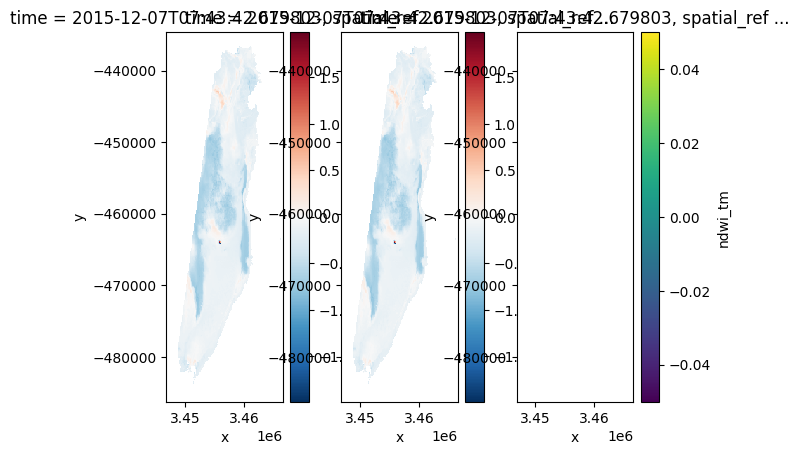

In [17]:
t = 0
t = t + 1
plt.subplot(1,3,1)
ds.isel(time=t).ndwi.plot()
plt.subplot(1,3,2)
ds.isel(time=t).ndwi_oli.plot()
plt.subplot(1,3,3)
ds.isel(time=t).ndwi_tm.plot()

    

In [12]:
ds.tss_measure

<xarray.DataArray 'tss_measure' (tss_measure: 10)> Size: 560B
array(['ndssi_rg_oli', 'ndssi_rg_tm', 'ndssi_bnir_oli', 'ti_yu_oli',
       'ti_yu_tm', 'tsm_lym_oli', 'tsm_lym_tm', 'tss_zhang_oli', 'spm_qiu_oli',
       'spm_qiu_tm'], dtype='<U14')
Coordinates:
    spatial_ref  int32 4B 6933
  * tss_measure  (tss_measure) <U14 560B 'ndssi_rg_oli' ... 'spm_qiu_tm'

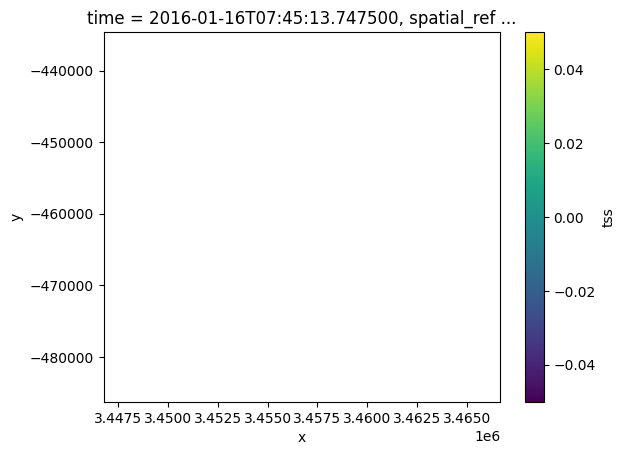

In [202]:
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].isel(time=t).plot()

#### Some derived variables to simplify the plotting process 

In [21]:
# going one step further here; pull out each tss variable, calibrate it to the lymburner distribution, take the median
ds['refvar'] = ds.where(ds.qa_score > 0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
i = 0
Q = .8
for tssvar in ds.tss_measure[:] :
    
    # pull out values as a new variable
    ds['tempvar'] = ds.where(ds.qa_score > 0).tss.loc[{'tss_measure' : tssvar}]
    # match that variable to the target (lymburner) distribution
    ds['tempvar'] = cpf_match(ds.tempvar,ds.refvar,5)
    # push it back to the source variable space
    if not tssvar == 'tsm_lym_oli':
        ds.tss.loc[{'tss_measure' : tssvar}] = ds.tempvar
        print('updating ',tssvar.item())




updating  ndssi_rg_oli
updating  ndssi_rg_tm
updating  ndssi_bnir_oli
updating  ti_yu_oli
updating  ti_yu_tm
updating  tsm_lym_tm
updating  tss_zhang_oli


/opt/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


updating  spm_qiu_oli
updating  spm_qiu_tm


/opt/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0 ndssi_rg_oli


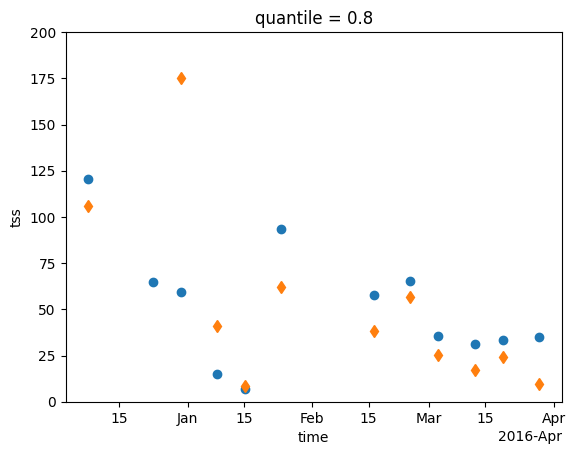

In [65]:
i = -1
i = i +1 

if i < ds.tss_measure.size:
    tssvar  = ds.tss_measure[i].item()
    print(i,tssvar)
    
    ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].quantile(Q,dim=('x','y')).plot(marker = 'o',linestyle = '',ylim=(0,200))
#    ds['tss_lym_oli'].quantile(Q,dim=('x','y')).plot(marker = 'x',linestyle = '',color = 'k',ylim=(0,200))
    ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : tssvar}].quantile(Q,dim=('x','y')).plot(marker = 'd',linestyle = '',ylim=(0,200))
    

In [ ]:
ds.tempvar.quantile(Q,dim=('x','y')).plot(marker = 'o',linestyle = '',ylim=(0,200))
ds.refvar.quantile(Q,dim=('x','y')).plot(marker = 'x',linestyle = '',color = 'k',ylim=(0,200))
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : tssvar}].quantile(Q,dim=('x','y')).plot(marker = 'd',linestyle = '',ylim=(0,200))
i = i + 1
print(tssvar.item(),'tsm_lym_oli',tssvar.item())

In [ ]:
# capture the median value of tss as a variable to simplify future work...
ds['tss_median']            = ds.where(ds.qa_score>0)       .tss.median(dim=('tss_measure'))
ds_annual['tss_agm_median'] = ds_annual.tss.median(dim=('tss_measure')).isel(time=1)

ds['tss_excess'] = ds.tss_median.where(ds.tss_median > ds_annual.tss_agm_median) - ds_annual.tss_agm_median

In [176]:
(ds.lym + 35.1 - ds_annual.tss_agm_median).quantile(.5,dim=('x','y'))

<xarray.DataArray (time: 24)> Size: 192B
array([ 0.26103407, 10.75413415, -0.63003275,  3.00717317, -1.41420258,
       -6.67835658, -5.63744713, -7.778738  , -4.04144488,  0.49081356,
        1.12350316,  6.99861018,  3.28926277,  0.87057734,  2.90172865,
        1.62408231, -1.99528972, -1.09788183,  4.06287482, -2.90542132,
        0.09298646, -2.49635864, 10.75755893,  4.05491538])
Coordinates:
  * time      (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 2016-...
    quantile  float64 8B 0.5

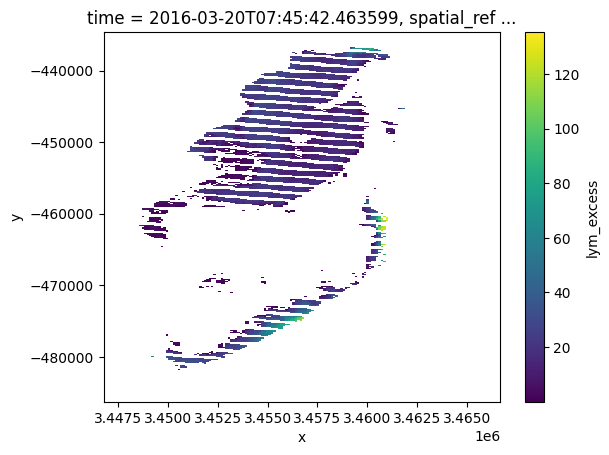

In [201]:
#t = 0
t = t + 1
ds.lym_excess.isel(time=t).plot()

In [97]:
%run /home/jovyan/AdamsWork/_AL_functions.ipynb

Loading AL_functions


In [99]:
ds.time.astype('float')

<xarray.DataArray 'time' (time: 24)> Size: 192B
array([1.44938825e+18, 1.44947422e+18, 1.45085662e+18, 1.45146179e+18,
       1.45154790e+18, 1.45215308e+18, 1.45223902e+18, 1.45284419e+18,
       1.45293031e+18, 1.45353549e+18, 1.45362142e+18, 1.45431272e+18,
       1.45560898e+18, 1.45569513e+18, 1.45630030e+18, 1.45638621e+18,
       1.45699138e+18, 1.45707753e+18, 1.45768271e+18, 1.45776861e+18,
       1.45837377e+18, 1.45845994e+18, 1.45906511e+18, 1.45915100e+18])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [104]:
piecewise_linreg(ds.time.astype('float'),means,keepnans=True,test=False)[0][1]

array([108.073, 108.08 , 127.734, 116.118,  98.282, 117.437, 146.435,
       134.781,  95.285,  71.041,  64.827,  57.821,  50.883,  44.283,
        39.332,  56.348,  71.043,  52.794,  50.876,  85.195,  85.64 ,
        38.864,  18.179,  18.18 ])

In [126]:
means.mean()

<xarray.DataArray 'tss_excess' ()> Size: 8B
array(77.17546667)
Coordinates:
    spatial_ref  int32 4B 6933

In [250]:
for i in np.arange(0,ds.time.size):
    print(i, ds.time[i].values,lym[i].values,ds.lym_excess.mean(dim=('x','y'))[i].values)

0 2015-12-06T07:50:46.715176000 54.41800148459096 54.41800148459096
1 2015-12-07T07:43:42.679803000 77.3319821553746 77.3319821553746
2 2015-12-23T07:43:43.494509000 58.32205309198826 58.32205309198826
3 2015-12-30T07:49:52.823376000 46.767687227911104 46.767687227911104
4 2015-12-31T07:44:58.398838000 48.747003674383215 48.747003674383215
5 2016-01-07T07:51:16.617310000 45.37818146883876 45.37818146883876
6 2016-01-08T07:43:38.668061000 33.54633450937599 33.54633450937599
7 2016-01-15T07:49:50.839894000 26.369649195794878 26.369649195794878
8 2016-01-16T07:45:13.747500000 22.893534868214935 22.893534868214935
9 2016-01-23T07:51:29.503810000 41.955714710490476 41.955714710490476
10 2016-01-24T07:43:39.921891000 59.744399750792546 59.744399750792546
11 2016-02-01T07:45:23.506272000 52.01385777413965 52.01385777413965
12 2016-02-16T07:49:41.042103000 42.04853071354155 42.04853071354155
13 2016-02-17T07:45:27.599780000 44.93310111478829 44.93310111478829
14 2016-02-24T07:51:38.430596000 3

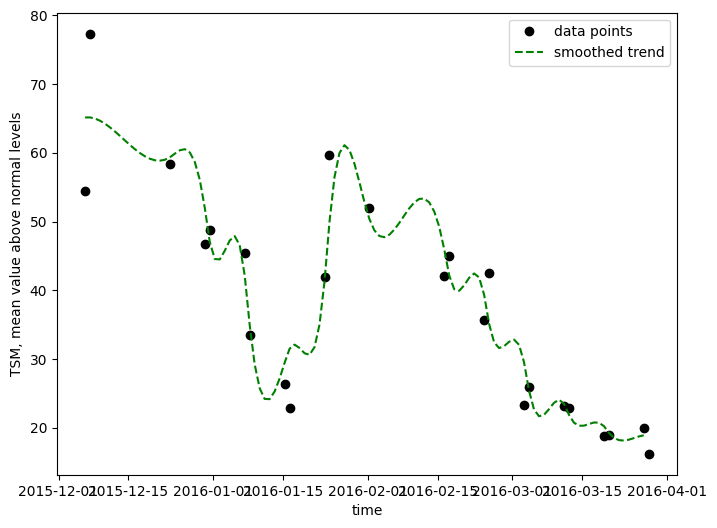

In [236]:
# use the lymburner TSI algorithm for now because it produces consistent results. 

ds['lym']        = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : ['tsm_lym_oli','tsm_lym_tm']}].median(dim=('tss_measure'))

# 35.1 is the bias between the annual geomedian values and the median values observed here using the lymburner model
ds['lym_excess'] = ds.where(ds.qa_score>0).where(ds.lym + 35.1 > ds_annual.tss_agm_median).lym - ds_annual.tss_agm_median + 35.1

# pull out into a simple array, smooth a couple of times and fit a quadratic spline
lym = ds.where(ds.qa_score>0).lym_excess.mean(dim=('x','y'))
slym = piecewise_linreg(ds.time.astype('float'),lym,keepnans=True,test=False)[0][1]
sslym = piecewise_linreg(ds.time.astype('float'),slym,keepnans=True,test=False)[0][1]

smoothed = sp.interpolate.interp1d(ds.time,sslym,kind='cubic',fill_value='extrapolate')
t_new    = pd.date_range(ds.time.min().values, ds.time.max().values, freq='1D')

plt.figure(figsize=[8,6])
plt.subplot(1,1,1)

plt.xlabel('time')
plt.ylabel('TSM, mean value above normal levels')

plt.plot(ds.time,lym,'k',linestyle="", marker="o",label='Data Points')  
#plt.plot(ds.time,slym,'b',linestyle="", marker="o",label='LYM TSI excess')  
plt.plot(t_new,smoothed(t_new),'g',linestyle="--", marker="",label='LYM TSI excess')  




plt.legend(['data points','smoothed trend'])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

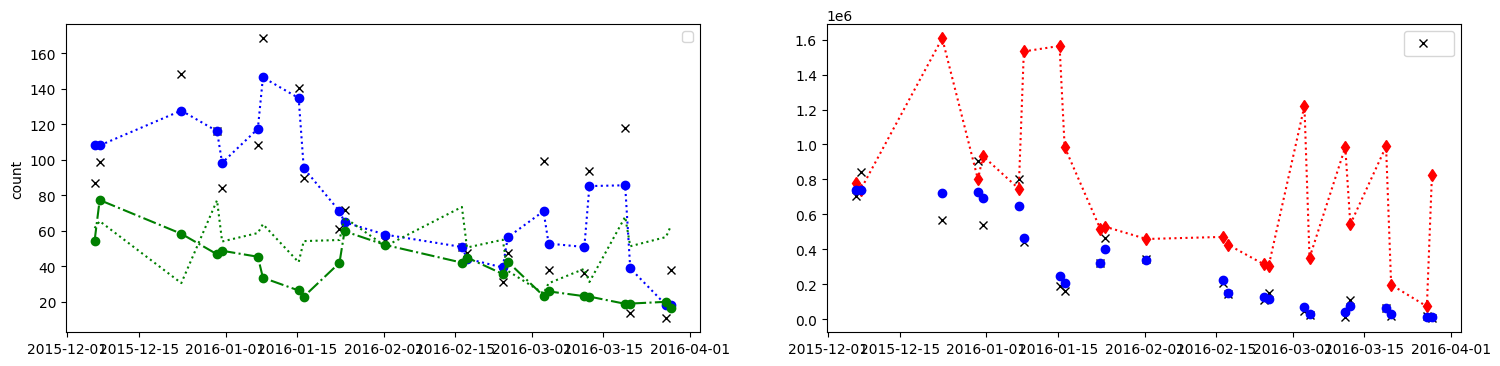

In [202]:
excess_counts  = ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median.count(dim=('x','y'))
clear_counts   = ds.where(ds.qa_score>0).tss_median.count(dim=('x','y'))
maxclearcounts = clear_counts.max()
area_excess    = excess_counts/clear_counts  * maxclearcounts
confidence     = clear_counts / maxclearcounts

means  = ds.tss_excess.mean(dim=('x','y'))
totals = ds.tss_excess.sum(dim=('x','y'))
smeans = piecewise_linreg(ds.time.astype('float'),means,keepnans=True,test=False)[0][1]
swmeans = piecewise_linreg(ds.time.astype('float'),means*confidence,keepnans=True,test=False)[0][1] / confidence
maxcount = counts.max()

#confidence = ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median.count(dim=('x','y'))

stotals = piecewise_linreg(ds.time.astype('float'),totals,keepnans=True,test=False)[0][1]
nstotals = piecewise_linreg(ds.time.astype('float'),totals,keepnans=True,test=False)[0][1]/counts * maxcount



plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

plt.xlabel('')
plt.ylabel('count')
plt.legend(['number of pixels contributing to the estimate'])

plt.plot(ds.time,means,'k',linestyle="", marker="x",label='Means')  
plt.plot(ds.time,smeans,'b',linestyle=":", marker="o",label='Smoothed Means')  
plt.plot(ds.time,ds.lym_excess.mean(dim=('x','y')),'g',linestyle="-.", marker="o",label='LYM TSI excess')  
#plt.plot(ds.time,swmeans,'r',linestyle=":", marker="d",label='Smoothed Means')  
#plt.plot(ds.time,smoothfunction(ds.fpm_percent,5)(ds.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  
#plt.legend(['mean excess mg/l','smoothed means','smoothed weighted means'])
plt.plot(ds.time,confidence * means.mean(),'g',linestyle =':')

plt.subplot(1,2,2)
plt.plot(ds.time,totals,'k',linestyle="", marker="x",label='total observed excess')  
plt.plot(ds.time,nstotals,'r',linestyle=":", marker="d",label='smoothed total excess normalised by count')  
plt.plot(ds.time,stotals,'b',linestyle="", marker="o",label='confidence')  



plt.legend([''])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

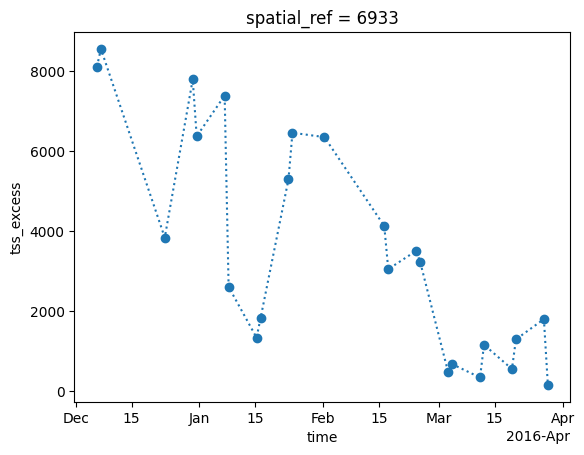

In [86]:
ds.tss_excess.count(dim=('x','y')).plot(marker = 'o',linestyle=':')

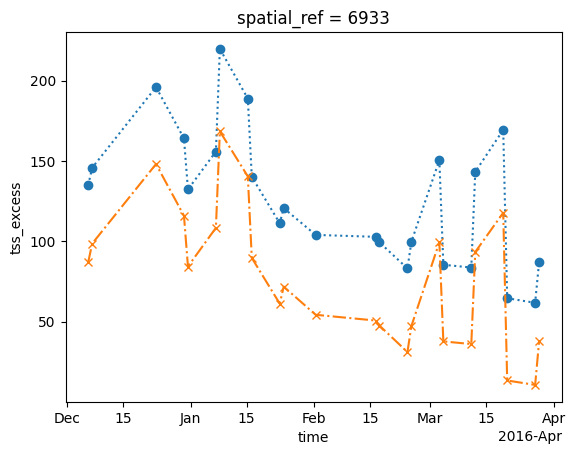

In [81]:
ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median .mean(dim=('x','y')).plot(linestyle=':',marker='o')
ds.where(ds.qa_score>0).tss_excess .mean(dim=('x','y')).plot(linestyle='-.',marker='x')



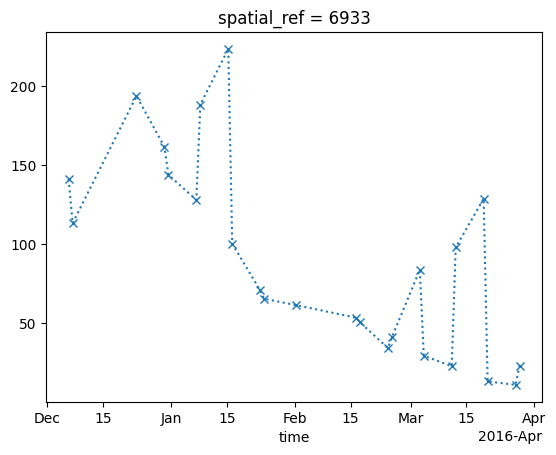

In [72]:
# restricting to the northern half of the lake gives a better response
plt.title=('tss excedences in the northern half of the lake')
(ds.where(ds.qa_score>0).tss_excess[:,300:,:] - ds_annual['tss_agm_median']).mean(dim=('x','y')) \
     .plot(linestyle=':',marker='x')

plt.show()


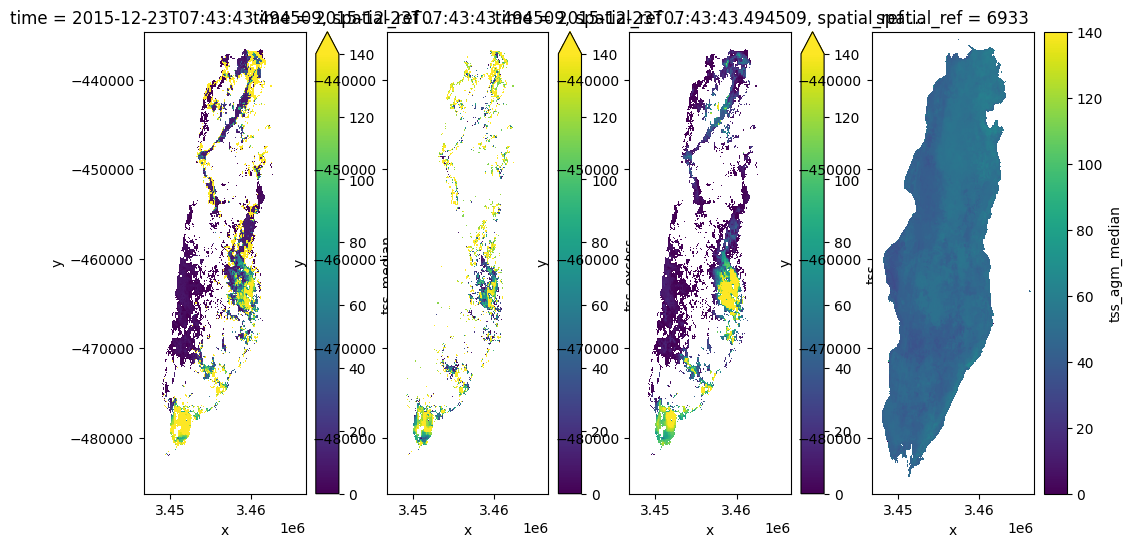

In [90]:
t = t +1
#t = 0
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
#ds.where(ds.qa_score>0).isel(time=t).tss.median(dim=('tss_measure')).plot(vmin=0,vmax = 140,robust=True)
ds.where(ds.qa_score>0).isel(time=t).tss_median.plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,2)
#ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).isel(time=t).tss_median.plot(vmin=0,vmax = 140,robust=True)
ds.where(ds.qa_score>0).isel(time=t).tss_excess.plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,3)
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].isel(time=t).plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,4)
#ds_annual.tss.median(dim=('time','tss_measure')).plot(vmin=0,vmax=140)
ds_annual.tss_agm_median.plot(vmin=0,vmax=140)


In [244]:
%run /home/jovyan/AdamsWork/_AL_functions.ipynb

Loading AL_functions


In [245]:
# --- a function to produce a smoothed timeseries graph ---
#     the data should be a single-dimenson dataarray with times

def smoothfunction(data,iterations=2):
    xy = piecewise_linreg(\
        data.time.astype('float'),\
        data,\
        keepnans=True)[0]
     
    for i in np.arange(0,iterations):
        xy = piecewise_linreg(\
            data.time.astype('float'),\
            xy[1],\
            keepnans=True)[0]

    # --- extract the valid values and fit a quadratic to them
    xlist = [] ; ylist = []
    for i in range(0,data.time.size):
        if ~np.isnan(xy[1][i]) :
             xlist.append(data.time[i].values)
             ylist.append(xy[1][i])

    xlist = np.asarray(xlist)
    ylist = np.asarray(ylist)
 
    q_interp   = sp.interpolate.interp1d(xlist,ylist,kind='quadratic',fill_value='extrapolate')
    #re-process through the smoother..
    xy = piecewise_linreg(\
        np.arange(0,data.time.size),\
        q_interp(data.time),\
        keepnans=True)[0]
    
    xlist = [] ; ylist = []
    for i in range(0,data.time.size):
        if ~np.isnan(xy[1][i]) :
             xlist.append(data.time[i].values)
             ylist.append(xy[1][i])
    xlist = np.asarray(xlist)
    ylist = np.asarray(ylist)
    return sp.interpolate.interp1d(xlist,ylist,kind='slinear',fill_value='extrapolate')

In [173]:
# make a time-series summary for the water area:
ts_ndvi_tm = ds.where(ds.tm).ndvi.mean(dim=('x','y'))
ts_ndvi_oli = ds.where(ds.oli).ndvi.mean(dim=('x','y'))
#ts_ndvi_msi = ds.where(ds.msi).ndvi.mean(dim=('x','y'))
ts_ndvi     = ds.ndvi.mean(dim=('x','y'))

In [234]:
tss_data = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))

<xarray.DataArray 'tss' (time: 24)> Size: 192B
array([73.13248964, 47.90248981, 38.64781265, 48.16363038, 71.47167219,
       72.56756283, 38.10253846, 11.33066666, 36.82881214, 65.70080135,
       37.60550318, 75.77363794, 38.12856539, 45.46132685, 44.09911217,
       37.61302072, 24.87930519, 28.68209091, 43.23499118, 30.77161373,
       37.02688195, 48.87970975, 58.78127379, 37.78580939])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [268]:
ds_annual

<xarray.Dataset> Size: 31MB
Dimensions:              (time: 2, y: 430, x: 166, tss_measure: 6,
                          chla_measure: 1)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2015-07-02T11:59:59.999999...
  * y                    (y) float64 3kB -4.862e+05 -4.861e+05 ... -4.347e+05
  * x                    (x) float64 1kB 3.447e+06 3.447e+06 ... 3.467e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 432B 'ndssi_rg_oli_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U14 56B 'ndci_oli54_agm'
Data variables: (12/26)
    oli02_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli03_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli04_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli05_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli06_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli07_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    ...                   ...
    oli03_agmr           (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli02_agmr           (time, y, x) float64 1MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 7MB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 1MB nan nan ... nan
    tss_agm_med          (time, y, x) float64 1MB nan nan nan ... nan nan nan
    chla_agm_med         (time, y, x) float64 1MB nan nan nan ... nan nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [278]:
ds['lym'] = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
ds['lym_delta'] = ds.lym - ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].mean(dim='time')

In [280]:
ds.lym_delta.mean(dim=('x','y'))

<xarray.DataArray 'lym_delta' (time: 24)> Size: 192B
array([         nan,  18.05933895,  -4.57568718,  -2.45712517,
                nan,          nan, -25.97221573, -33.71519756,
                nan,          nan,   1.96146237,          nan,
        -3.12984779,          nan,          nan,  -8.10640689,
       -23.06861342,          nan,          nan, -23.52105842,
       -20.59099846,          nan,          nan, -19.07834044])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [276]:
ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].mean(dim='time')

<xarray.DataArray 'tss' (y: 430, x: 166)> Size: 571kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 3kB -4.862e+05 -4.861e+05 ... -4.348e+05 -4.347e+05
  * x            (x) float64 1kB 3.447e+06 3.447e+06 ... 3.466e+06 3.467e+06
    spatial_ref  int32 4B 6933
    tss_measure  <U18 72B 'tsm_lym_oli_agm'

(-100.0, 200.0)

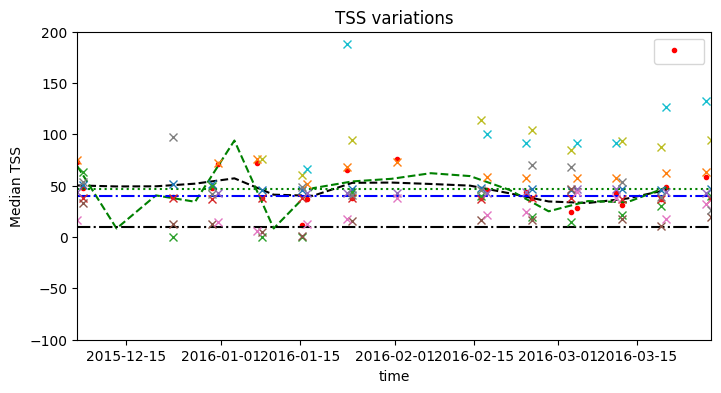

In [267]:
plt.figure(figsize=[18,4])
plt.subplot(1,2,1)
ds['lym'] = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
ds['lym_delta'] = ds.lym - ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}]




tssdata        = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))
tsslym         = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].median(dim=('x','y'))
tssdata        = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))


t              = tssdata.time
t_new          = pd.date_range(t.time.min().values, t.max().values, freq='W')  
tss_interp     = sp.interpolate.interp1d(t,(piecewise_linreg(np.arange(0,t.size),tssdata)[0][1]),kind='quadratic',fill_value='extrapolate')
tss_intlym     = sp.interpolate.interp1d(t,(piecewise_linreg(np.arange(0,t.size),tsslym)[0][1]),kind='quadratic',fill_value='extrapolate')



plt.plot(t,tssdata,'r',linestyle="", marker=".",label='')  
plt.plot(t_new,smoothfunction(tssdata,1)(t_new),'k',linestyle="--", marker="",label='Smoothed NDVI')  
plt.plot(t_new,tss_interp(t_new),'g',linestyle="--", marker="",label='Smoothed NDVI')  
plt.plot(t_new,tss_intlym(t_new),'g',linestyle="--", marker="",label='Smoothed NDVI')  

plt.axhline(y=ds_annual.tss.median(),color='g',linestyle=':')
plt.axhline(y=ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].median(),color='b',linestyle='-.')
plt.axhline(y=ds       .where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'    }].median(),color='k',linestyle='-.')

set_hue = ds.tss_measure
plt.plot(t,ds.tss.median(dim=('x','y')),linestyle='',marker='x')
#set_hue=wq_summary.tss_measure
#ax1.plot(wq_summary.time,wq_summary['tss']
#         .loc[placename,:],linestyle='dotted')
#ax1.plot(wq_summary.time,wq_summary['tss']
#         .loc[placename,:].
#         median(dim='tss_measure'),linestyle='solid')

plt.title('TSS variations')
                 
plt.xlabel('time')
plt.ylabel('Median TSS')
plt.legend([''])

# --- parameters for the range of the plot --- 
ymin  = -100;
ymax  = 200
xmin,xmax   = np.min(t),np.max(t)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

data = ts_ndvi
t    = ts_ndvi.time
plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,'r',linestyle="", marker=".",label='Mean NDVI - TM')  
plt.plot(ts_ndvi_oli.time,ts_ndvi_oli,'g',linestyle="", marker=".",label='Mean NDVI')  
#plt.plot(ts_ndvi_msi.time,ts_ndvi_msi,'b',linestyle="", marker=".",label='Mean NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_tm)(ts_ndvi.time),'r',linestyle=":", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_oli)(ts_ndvi.time),'g',linestyle=":", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_msi,4)(ts_ndvi.time),'b',linestyle=":", marker="",label='Smoothed NDVI')  
plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi,5)(ts_ndvi.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,xy[1],'r',linestyle="--", marker="",label='Smoothed NDVI')  

plt.title('NDVI variations')
                 
plt.xlabel('time')
plt.ylabel('NDVI')
plt.legend(['TM','OLI','MSI'])

# --- parameters for the range of the plot --- 
ymin  = 0;
ymax  = 1
xmin,xmax   = np.min(t),np.max(t)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

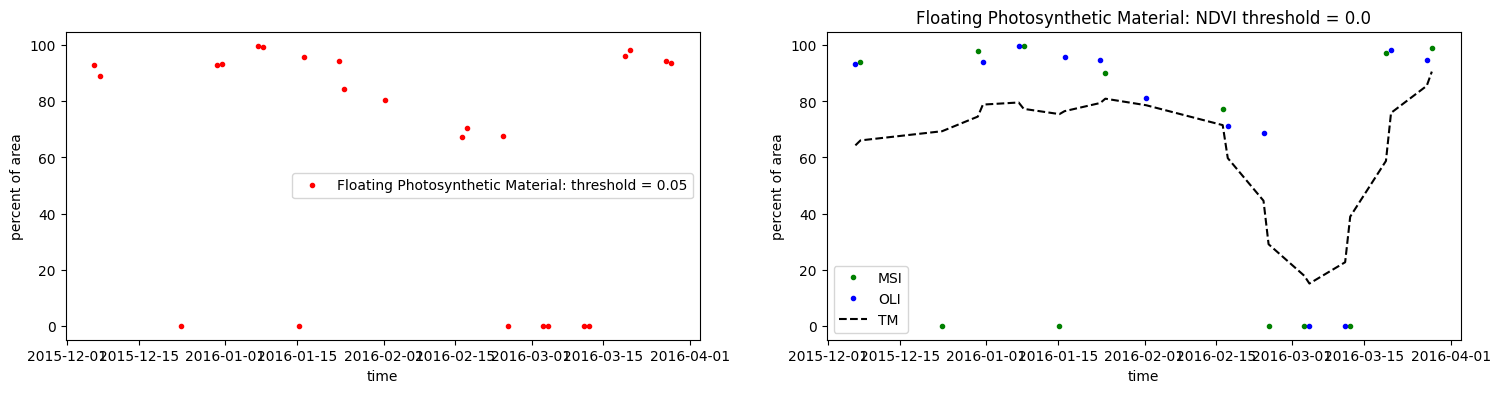

In [175]:
plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.05
ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count

plt.plot(ds.where(~np.isnan(ds.fpm_percent)).time,ds.where(~np.isnan(ds.fpm_percent)).fpm_percent,
#plt.plot(ds.time,ds.ndvi_total_count,
        'r',
         linestyle="", 
         marker=".",
         label='count'
        )
plt.xlabel('time')
plt.ylabel('percent of area')
plt.legend(['Floating Photosynthetic Material: threshold = '+str(fpm_threshold)])

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.0
ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count

plt.subplot(1,2,2)
#plt.plot(ds.time,ds.fpm_percent              ,'k',linestyle="",marker=".",label='FPM percent')

if 'msi' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.msi),'r',linestyle="",marker=".",label='FPM percent')
if 'oli' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.oli),'g',linestyle="",marker=".",label='FPM percent')
if 'tm' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.tm ),'b',linestyle="",marker=".",label='FPM percent')
plt.plot(ds.time,smoothfunction(ds.fpm_percent,5)(ds.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  

plt.xlabel('time')
plt.ylabel('percent of area')

plt.title('Floating Photosynthetic Material: NDVI threshold = '+str(fpm_threshold))
plt.legend(['MSI','OLI','TM'])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

In [149]:
# --- A Function to normalise the WQ measures ---

def normalise_water_quality_measures(ds0,np_data_dict,water_frequency_threshold=0,verbose=True,test=False):
    if test or verbose : print('Applying scale and offset to wq variables..')

    ds = ds0.copy(deep=True)   #without this the ds values do change outside of the function

    #run through all the wq measures; ds should have a dimension called 'tss_measure' and another called 'chla_measure'. 
    for mmt_type in ['tss','chla'] :
        for mmt in list(ds[mmt_type+'_measure']) :
            measurement = str(mmt.values)+'_agm'       # add the suffix - legacy of the annual geomedians used to develop the normalisation parameters
            scale  = np_data_dict[measurement]['scale']
            offset = np_data_dict[measurement]['offset']
            measurement = measurement[:measurement.find('_agm')] # removes the '_agm' suffix again!
            ds[mmt_type].loc[:,:,:,measurement] = ds[mmt_type].loc[:,:,:,measurement] * scale + offset
    
    #take the median of the tss and chla measurements from now on:
    water_frequency_threshold=0
    tss_index_list  = ds.tss_measure   # --- which tss measures to include; in practice this include them all  ----
    ds['tss_agm_med' ] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.tss.loc[:,:,:,tss_index_list].median(dim=('tss_measure')),np.nan)

    chla_index_list = ds.chla_measure  # --- which chla measures to include; by default, include them all ----
    ds['chla_agm_med'] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.chla.loc[:,:,:,chla_index_list].median(dim=('chla_measure')),np.nan)

    #drop excess material
    if not test:
        ds = ds.drop_vars('tss','chla')
    return ds

#### Exploring QA scores and parameters 
- I take 1.4 as a base, and use multiples of that; (2 for msi and oli, 3 for tm) 
- to bring back floating algal blooms, which will otherwise be removed, accept pixels that have an ndvi > 0.5 and ralb < 2.8
- test this on the lake victoria 'turbid' data area, for the first half of 2018
- Selection rule for ralb > -1.4 is needed with MSI to pull out cloud shadow

In [163]:
i = 0

In [164]:
#i = 15   #lake vic 2015-05-03

t = ds.time[i]
print(i)

# figure out if we are using an oli or a tm image;

oli_slice = [False,'qa_score','qa_ralb','qa_rsad','ci_score']
tm_slice  = [False,'qa_score','qa_ralb','qa_rsad','ci_score']
msi_slice = [False,'qa_score','qa_ralb','qa_rsad','ci_score']


oli_score_upper      = 1.4 * 2   # this seems best ...
msi_score_upper      = 1.4 * 2   # this seems best ...
tm_score_upper       = 1.4 * 3   # should need higher threshold for tm v oli ... not a nice step to take ..

upper_albedo = 2.0
upper_albedo = 3.0  # default filter cuts in a 2.8 so no point in going over that ... 
upper_albedo = 2.8  #lake vic 2018-04-27 benefits from relaxing to 2.8
lower_albedo = -1.4
lower_albedo = -2.
lower_albedo = -1.9 #this cuts out most cloud shadow, but can't go lower 
#lower_albedo = -1.8 starts to cut out real data in msi

upper_rsad   = 7
upper_rsad   = 6
upper_rsad   = 3
upper_rsad   = 4
upper_rsad   = 4.5
#upper_rsad   = 5 
rsad_factor = 0.4
ci_score_lower = 0
ci_cut     = 1   #one does not pick up key features


if t in list(ds_oli.time):
    oli_slice[0]        = True
    oli_timeindex       = list(ds_oli.time).index(t)
    prefix = 'qa'
    score_upper = oli_score_upper
    print('OLI')

else :
    if t in list(ds_tm.time):
        tm_slice[0]  = True
        tm_timeindex = list(ds_tm.time).index(t)
        prefix = 'qa'
        score_upper = tm_score_upper
        print('TM')
    else :
        if t in list (ds_msi.time):
            msi_slice[0]  = True
            msi_timeindex = list(ds_msi.time).index(t)
            prefix = 'qa'
            score_upper = msi_score_upper
            print('MSI')
            

# cumulative distribution stats:
start = 0;step=.05;stop=1+step

x    = np.arange(start,stop,step)
size = x.size
data = np.zeros([4,x.size])
data[0] = x
j = 0

for percent in x:
    k = 1
    string = 'Quantile = '+str(percent)+'  '
    for var in list(('ralb','rsad','score')):
        string = string + '  '+var+str(' : ')
        v      =  ds[prefix+'_'+var].sel(time=t).quantile(percent,).round(3).item()
        string = string+str(v)
        data[k,j] = v
        k = k + 1
    j = j+1
    print(string)


plt.figure(figsize=[12, 6])
plt.subplot(1,2,1)

plt.plot(data[1],data[0],'b',linestyle="--", marker=".",label='rsalb')  #ralb
plt.plot(data[2],data[0],'g',linestyle="-.", marker="X")  #rsad
plt.plot(data[3],data[0],'r',linestyle="-", marker="X")  #score
plt.axvline(x=0 ,linestyle=':',color='k')
plt.axvline(x=1.4 * 4,linestyle=':',color='r')
plt.axvline(x=1.4 * 3,linestyle=':',color='b')
plt.axvline(x=1.4 * 2,linestyle=':',color='g')

plt.title('distributions')
                 
plt.xlabel('value')
plt.ylabel('percentile')
plt.legend(['ralb','rsad','score'])

# --- parameters for the range of the plot --- 
ymin  = 0;
xmin   = np.max([np.min(data[1:,:]) * 1.5,-100])

xmax   = np.min([np.max(data[1:,:]) * 1.5,100])

plt.xlim(xmin,xmax)

plt.subplot(1,2,2)

i = i
print(i)
time = ds.time[i]
print(time.dt.year.item(),'-',time.dt.month.item(),'-',time.dt.day.item(),i,oli_slice[0],tm_slice[0])



#plt.figure(figsize=[12, 6])
if oli_slice[0]:
    print('plotting OLI points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color='c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')
if tm_slice[0]: 
    print('plotting TM points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')
if msi_slice[0]: 
    print('plotting MSI points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')


plt.plot(0,0,marker='d',color='r')
t = np.linspace(0,2*np.pi,100)
r0 = 1.4 

x,y = np.cos(t)/rsad_factor,np.sin(t)
#plt.plot(x*1*r1,y*r0,linestyle='-.',color='g')
#plt.plot(x*2*r1,y*2*r0,linestyle='--',color='b')
#plt.plot(x*score_upper*r1,y*score_upper*r0,linestyle='--',color='r')
plt.plot(score_upper*x,score_upper*y,linestyle='dotted',color='r')
plt.plot(2*r0*x,2*r0*y,linestyle='dotted',color='g')
#plot the nominal change index = 0 curve
y = np.linspace(-5,5,30)
plt.plot(y**2,y,linestyle='dotted',color='k')

plt.axvline(x=0,color='r',linestyle=':')
plt.axvline(x=0+2*r0/rsad_factor,color='g',linestyle=':')
plt.axvline(x=upper_rsad,color='k',linestyle='-')
plt.axhline(y=0-2*r0,color='g',linestyle=':')
plt.axhline(y=0+2*r0,color='g',linestyle=':')
plt.axhline(y=lower_albedo,color='k',linestyle='-')
plt.axhline(y=upper_albedo,color='k',linestyle='-')

plt.xlim([0,40])
plt.ylim([-20,20])

plt.show()

print('original data')    

if oli_slice[0] == True :
    rgb(ds_oli,
        #    col='time',
        #    col_wrap = 4,
        bands=['oli04','oli03','oli02'],
        index =oli_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )

if tm_slice[0] == True:
    rgb(ds_tm,
        #    col='time',
        #    col_wrap = 4,
        bands=['tm03','tm02','tm01'],
        index =tm_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )
if msi_slice[0] == True:
    rgb(ds_msi,
        #    col='time',
        #    col_wrap = 4,
        bands=['msi04','msi03','msi02'],
        index =msi_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )


if oli_slice[0]: 
    qa_var = oli_slice[1]
    qa_ralb = oli_slice[2]
    qa_rsad = oli_slice[3]
    qa_ci   = oli_slice[4]
    rgbbands=['oli04','oli03','oli01']
    ndvibands=['oli05','oli04']
    cutoff = score_upper
    
if tm_slice[0] : 
    qa_var = tm_slice[1]
    qa_ralb = tm_slice[2]
    qa_rsad = tm_slice[3]
    qa_ci   = tm_slice[4]
    rgbbands=['tm03','tm02','tm01']
    ndvibands=['tm04','tm03']
    cutoff = tm_score_upper

if msi_slice[0] : 
    qa_var = msi_slice[1]
    qa_ralb = msi_slice[2]
    qa_rsad = msi_slice[3]
    qa_ci   = msi_slice[4]
    rgbbands=['msi04','msi03','msi02']
    ndvibands=['msi8a','msi04']
    cutoff = msi_score_upper
    
print('QA var:  ',qa_var, rgbbands)


# --- just the qa variable ---
plt.show()
print('default filter')    

rgb(ds.where(ds[qa_var]>0,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_var]<cutoff,ds[qa_ralb]>lower_albedo),ds[qa_ralb]<upper_albedo),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )
plt.show()

# --- qa variable with additional overlays to fine-tune.. ---
print('default filter further constrained by albedo and spectral angle deviation ')    

rgb(ds.where(np.logical_and
             (
             np.logical_and(ds[qa_var]>0,ds[qa_rsad]<upper_rsad),
             np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo)
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()

# --- no qa variable; additional overlays replace... ---

print('simple filter constrained independently by albedo and spectral angle deviation ')    

rgb(ds.where(np.logical_and
             (
             np.logical_and(True,ds[qa_rsad]<upper_rsad),
             np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo)
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('default further constrained by albedo')    

rgb(ds.where(np.logical_and
             (
                 np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),
                 ds[qa_var]>0
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('default filter further constrained by rsad')    

rgb(ds.where(np.logical_and(ds[qa_rsad]<upper_rsad,ds[qa_var]>0),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )


plt.show()

print('change indicator; high rsad, low ralb')    
# --- change indicator ---
#rgb(ds.where(np.logical_and(ds[qa_var]<cutoff,ds[qa_ralb]>lower_albedo),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
ci_cut = 0
#ds['change_inidicated'] = ds.where(np.logical_and
#                               (
#                                np.logical_and(ds[qa_rsad]>upper_rsad,ds[qa_var]>cutoff),
#                                ds[qa_ralb]<upper_albedo
#                               ),
#                               np.nan)

rgb(ds.where(np.logical_and(
                            ds.ci_score>ci_score_lower+upper_rsad*rsad_factor,
                            ds[qa_var]<=0
                            ),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('ndvi')    

ndvi_threshold = 0.1
ndvi = (ds[ndvibands[0]]-ds[ndvibands[1]])/(ds[ndvibands[0]]+ds[ndvibands[1]])
xr.where(ndvi>ndvi_threshold,ndvi,np.nan).isel(time=i).plot(robust=True)

# --- photosynthetic surface material --- 
#ds['psm'] = ds.where(np.logical_and(ndvi > ndvi_threshold,ds['change_indicated'] == True),True,False)
                                    

i = i + 1
#i = 



0


AttributeError: 'str' object has no attribute 'time'

In [165]:
gc.collect()

76186

In [180]:
ds_annual.data_vars

Data variables:
    oli02_agm            (time, y, x) float64 1MB 607.0 623.0 ... 548.0 587.0
    oli03_agm            (time, y, x) float64 1MB 911.0 949.0 ... 815.0 841.0
    oli04_agm            (time, y, x) float64 1MB 1.054e+03 1.104e+03 ... 984.0
    oli05_agm            (time, y, x) float64 1MB 2.544e+03 ... 2.195e+03
    oli06_agm            (time, y, x) float64 1MB 2.998e+03 ... 2.334e+03
    oli07_agm            (time, y, x) float64 1MB 2.25e+03 ... 1.77e+03
    oli_agm_smad         (time, y, x) float32 571kB 0.01008 ... 0.001485
    oli_agm_emad         (time, y, x) float32 571kB 1.125e+03 ... 451.0
    oli_agm_bcmad        (time, y, x) float32 571kB 0.1076 0.1073 ... 0.05713
    oli_agm_count        (time, y, x) float64 1MB 12.0 11.0 12.0 ... 20.0 20.0
    wofs_ann_freq        (time, y, x) float32 571kB 0.0 0.0 0.0 ... 0.006183 0.0
    wofs_ann_clearcount  (time, y, x) float64 1MB 18.0 18.0 18.0 ... 31.0 32.0
    wofs_ann_wetcount    (time, y, x) float64 1MB 0.0 0.0 0.0 ... 

### Pixel corrections

In [ ]:
# --- dark Pixel correction, the 'dp_adjust' dictionary controls which variables are used as a reference, 
#     and which are changed in the dark-pixel correction
#     Add entries to cater for non-geomedian situations.

dp_adjust = { 
        'msi_agm': {'ref_var':'msi12_agm','var_list': ['msi04_agm','msi03_agm','msi02_agm','msi05_agm','msi06_agm', 'msi07_agm']},
        'oli_agm': {'ref_var':'oli07_agm','var_list': ['oli04_agm','oli03_agm','oli02_agm']},
        'tm_agm' : {'ref_var':'tm07_agm', 'var_list': ['tm04_agm','tm03_agm','tm02_agm','tm01_agm']}
        }
ds = R_correction(ds,dp_adjust,instruments,water_frequency_threshold_low,verbose=verbose,test=test)

### Hue; calculation of the hue value

In [ ]:
if not (('msi_agm') in instruments.keys()):
    print("skipping hue calculation as the msi_agm instrument is not in the dataset")
else: 
    ds['hue'] = hue_calculation(ds,instrument='msi_agm',test=test,verbose=verbose)[0]

In [ ]:
ds['owt_msi'] = OWT_pixel(ds,'msi_agm',water_frequency_threshold=0.8,resample_rate=3,verbose=False, test=True)        


### And we are Done... :)

In [ ]:
#export the dataset as an input for the next step:
ds.to_netcdf("../WP1.4/wp21_ds_"+placename+".nc")